# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *
from matlab.function_EMCCD_CMOS_calib import *

In [3]:
import PIL
import PIL.ExifTags as Exiftags

In [4]:
from matlab.tifmethods import readBigTifFile

In [5]:
windows = True
if windows:
    fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
else:
    fname = '/mnt/data/Anastasia/sample folder with NR data/image files/cell1_BeRST.tif'
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c752c34940>)

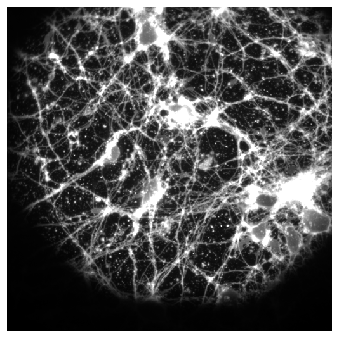

In [6]:
visualization(movie)

In [7]:
if windows:
    folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
    fname = r"\wave\cell4_7.tif"
    fwave = r"\wave\cell4_7.tif"
    fctrl = r"\control\cell4_8.tif"
    file_Berst='\cell4_BeRST.tif'
    foldercalib = "\EMCCD-CMOS calib\\"
else:
    folder = '/mnt/data/Anastasia/sample folder with NR data/image files/'
    fname = 'wave/cell1_1.tif'
    fwave = 'wave/cell1_1.tif'
    fctrl = 'control/cell1_2.tif'
    file_Berst='cell1_BeRST.tif'
    foldercalib = "EMCCD-CMOS calib/"


In [8]:
movie = readBigTifFile(folder+fname)
movie = movie.sum(axis=0) # sum(movie,axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c752d0f198>)

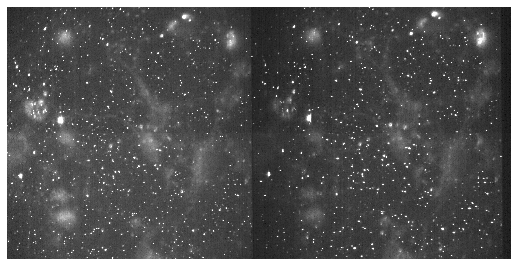

In [9]:
visualization(movie)

##     Mask generation and three fields alignment.

### cMOS camera fields alignment
### EMCCD mask generation
### Transposition of mask two CMOS images


In [10]:
from matlab.function_EMCCD_CMOS_calib import EMCCD_CMOS_calib

In [11]:
#file_wave='\cell1_BeRST.tif'
f=3 #averaging factor for the mask

#EMCCD-CMOS calib results
print(folder+foldercalib)
ax, ay, bx, by = EMCCD_CMOS_calib(folder+foldercalib)

C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files\EMCCD-CMOS calib\


In [12]:
print(ax, ay,bx, by)

0.7910246816347403 0.8152787153028243 74.96592913252289 -33.87204042892071


In [13]:
from matlab.tifmethods import *
info = readtifInfo(folder+file_Berst)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)
Stim=tile([-60, 0],Nframes//2);

movie = readBigTifFile(folder+file_Berst)
movie_sum = movie.sum(axis=0)
SizeX,SizeY = movie_sum.shape



In [14]:
CorCoef_wave = zeros((SizeX, SizeY))
for x in range(SizeX):
    for y in range(SizeY):
        temp = corrcoef(movie[:,x,y],Stim)
        CorCoef_wave[x,y]=temp[1,0];



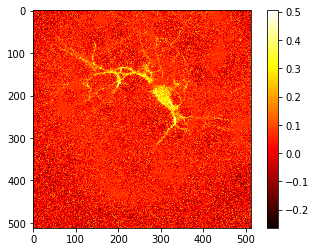

In [15]:
imshow(CorCoef_wave, cmap='hot')
colorbar()

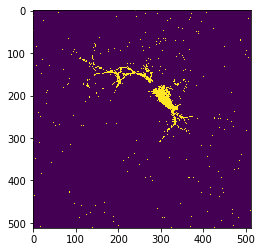

In [16]:
thld=mean(CorCoef_wave)+2.2*std(CorCoef_wave)
Mask_EMCCD=CorCoef_wave*1
Mask_EMCCD[Mask_EMCCD<thld]=0;
Mask_EMCCD[Mask_EMCCD>=thld]=1;
imshow(Mask_EMCCD);

In [17]:
#from matlab.make_mask import movavgy,movavgx

def movavgy (img, wind):
    sizeX, sizeY = img.shape
    imga=img*0
    wind2=wind//2
    for y in range(sizeY):
        for x in range(wind2,sizeX-wind2):
            imga[x,y]=nanmean(img[x-wind2:x+wind2+1,y])
    return imga
def movavgx (img, wind):
    return movavgy(img.transpose(), wind).transpose()


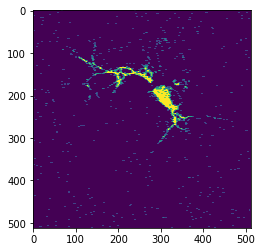

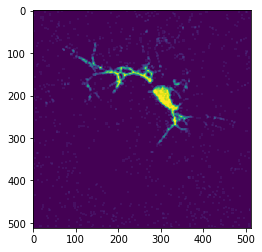

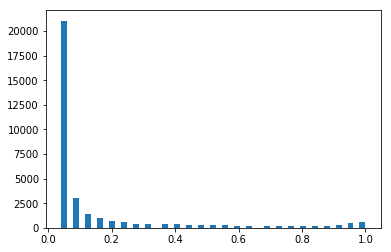

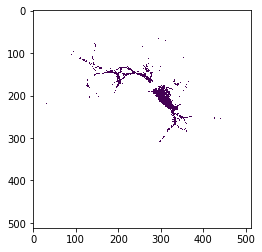

In [18]:
temp1=movavgx (Mask_EMCCD,5);
temp2=movavgy (temp1,5);
imshow(temp1)
figure()
imshow(temp2)
figure()
temp=temp2.flatten()
hist(temp[temp>0],51)
temp3=Mask_EMCCD*1;
temp3[temp2<=0.15]=nan;
temp3[temp3==0]=nan;
figure()
imshow(temp3)

In [19]:
#savetxt('Mask_CMOS_matrix.txt', Mask_CMOS)

NameError: name 'Mask_CMOS' is not defined

In [ ]:
f=3
temp1=movavgx(temp3,f);
Mask_EMCCD_exp=movavgy (temp1,f);
imshow(Mask_EMCCD_exp)

In [ ]:
imshow(Mask_EMCCD_exp)
ylim(512,-10)

In [ ]:
#import cv2

In [ ]:
#from matlab.make_mask import calib

def calib(Mask, ax, ay, bx, by):
    Mask_CMOS=zeros(Mask.shape);
    for Xc in range(Mask_CMOS.shape[1]):
        for Yc in range(Mask_CMOS.shape[0]):
            Xe=int(round(ax*Xc+bx));
            Ye=int(round(ay*Yc+by));
            if Xe>-1 and Xe<Mask.shape[1] and Ye>-1 and Ye<Mask.shape[0]:
                Mask_CMOS[Yc,Xc]=Mask[Ye, Xe];
    Mask_CMOS[isnan(Mask_CMOS)]=0
    
    #kernel=2
    #kernelm = cv2.UMat(ones((kernel,kernel),float32)/float(kernel)**2)
    #dilated = cv2.dilate(Mask_CMOS,kernel=kernelm)
    return Mask_CMOS #array(dilated.get())


In [ ]:
Mask_CMOS=calib(Mask_EMCCD_exp, ax, ay, bx, by)
imshow(Mask_CMOS)

##   Local maxima detection and ROI detection
### Local maxima detection
### Blinking coefficient and selection
### Neural-net?


In [ ]:
from matlab.calib import extractpeaks2d0,afintransf, CMOS_2fields_calib

In [ ]:
v = CMOS_2fields_calib(folder+foldercalib)

In [ ]:
print(v)

In [ ]:
calibim = readtifImage(folder+foldercalib+'calib_CMOS_2.tif')

In [ ]:
ptsB = extractpeaks2d0(calibim[:,:512])

In [ ]:
ptsR2 = 1.0*ptsB
ptsR2[:,0] += 512+v[0]
ptsR2[:,1] += v[1]
visualization(calibim,row_stack((ptsB[:100,:],ptsR2[:100,:])))

In [ ]:
dx, dy = 512+round(v[0]),round(v[1])

In [ ]:
print(dx, dy)

In [ ]:
#folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
fname = fwave
movie = readBigTifFile(folder+fname)
movie_sum = movie.sum(axis=0) # sum(movie,axis=0)


In [ ]:
info = readtifInfo(folder+fname)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)

In [ ]:
TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
Tacq = float(TacqStr)


In [ ]:
# Generating stimulation trace
Stim=tile([0, 0, -60, -60],Nframes//4);

In [ ]:
visualization(movie_sum)

In [ ]:
kernel = 5
ROIsize=5
km = ones((kernel,kernel),float32)#/float(kernel)**2
J = zeros(Mask_CMOS.shape)
rs2 = kernel//2
mx,my = Mask_CMOS.shape

for x in range(0,mx-kernel):
    for y in range(0,my-kernel):
        temp = km*movie_sum[x:(x+kernel),y:(y+kernel)]
        J[x+rs2,y+rs2] = temp.max()

In [ ]:
mx,my = Mask_CMOS.shape
pts = [] 
for x in range(2*ROIsize+1,mx-2*ROIsize):
    for y in range(2*ROIsize,my-2*ROIsize):
        if Mask_CMOS[x,y]>0 and J[x, y]==movie_sum[x, y]:
            pts.append([y, x])


pts = array(pts)

In [ ]:
visualization(movie_sum,pts,figsize=(14,14))

In [ ]:
x=pts[:,0]+dx
y=pts[:,1]+dy

In [ ]:
sel = x+floor(ROIsize/2)<movie_sum.shape[1]
sel = sel*(y+floor(ROIsize/2)<movie_sum.shape[0])
sel = sel*(y-floor(ROIsize/2)>0)
x = x[sel]
y = y[sel]

In [ ]:
ptsr=column_stack((x,y))
ptsb=pts*1
pts_all=row_stack((ptsb,ptsr))
visualization(movie_sum,pts_all,figsize=(14,14))

In [ ]:
ptsb.shape


##   Processing ROIs:
### Linearization of ROI
### Blinking substraction
### Stitching cycles
### Mobility



In [ ]:
movie.shape

In [ ]:
def MakeROIMovie(Movie,pts,ROIsize):

    NROI=shape(pts)[0]
    ROIs=zeros((2,ROIsize,NROI))
    ROIs_Movie=zeros((shape(Movie)[0],ROIsize,ROIsize,NROI))
    for i in range(NROI):
        # dimensions of ROIs_Movie: (X,Y,Frame,ROI#)
        # won't work for 1x1
        r2=(ROIsize-1)//2
        x0,xf = pts[i,0]-r2 , pts[i,0]+r2+1
        y0,yf = pts[i,1]-r2 , pts[i,1]+r2+1
        ROIs_Movie[:,:,:,i]=Movie[:, y0:yf , x0:xf]
    return ROIs_Movie

In [ ]:
NROI=shape(pts_all)[0]

In [ ]:
def extractLinearROIs(movie, pts_all, ROIsize):
    NROI=shape(pts_all)[0]
    Nframes, sizeY, sizeX = movie.shape
    ROIs_Movie = MakeROIMovie(movie,array(pts_all,dtype=int),ROIsize)
    # we reshape it to have ROIS as linear vectors
    Linear_ROIs_Movie=reshape(ROIs_Movie,(Nframes, ROIsize**2,NROI))
    
    # Sort pxs each frame
    Linear_ROIs_Movie.sort(axis=1)
    # We decide the background and the signal
    Linear_ROIs_Movie_Back=Linear_ROIs_Movie[:,0:ROIsize,:]
    Linear_ROIs_Movie_Signal=Linear_ROIs_Movie[:,ROIsize:,:]
    
    # Final signal and sum of the 2 channels
    Signal=sum(Linear_ROIs_Movie_Signal-mean(Linear_ROIs_Movie_Back, axis=1, keepdims=True), axis=1)/Tacq   
    Signal_2ch=Signal[:,0:NROI//2]+Signal[:,NROI//2:]
    
    return(Signal, Signal_2ch)

In [ ]:
Signal, Signal_2ch = extractLinearROIs(movie,pts_all, ROIsize)
temp = randint(Signal_2ch.shape[1])

plot(Signal_2ch[:,temp])


In [ ]:
def classifier0(Signal_2ch, threshold = 0.45):
    temp1=mean(Signal_2ch, axis=0)
    temp2=mean((Signal_2ch-temp1)**2, axis=0)
    temp3=mean((Signal_2ch-temp1)**3, axis=0)/temp2**(3.0/2.0)
    temp4=mean((Signal_2ch-temp1)**4, axis=0)/temp2**(4.0/2.0)
    classifier=(temp3**2+1)/temp4

    idx = (-classifier).argsort()
    # selecting ROIs

    ROI_selected=arange(len(classifier))[classifier>threshold]

    if sum(ROI_selected)==0:
        print('no ROI selected')
    return(classifier, ROI_selected)

In [ ]:
classifier, ROI_selected = classifier0(Signal_2ch, threshold = 0.45)

In [ ]:
temp = randint(Signal_2ch.shape[1])
#temp = 1
plot(Signal_2ch[:,temp])
print(temp,':',classifier[temp])
print(ROI_selected)

In [ ]:
def getSignalsep(Signal,ROI_selected,NROI = Signal.shape[0]//2):
    Signalsep=Signal[:,ROI_selected]
    Signalsep=column_stack((Signalsep, Signal[:,NROI//2+ROI_selected])) 
    return(Signalsep)


In [ ]:
Signal_wave = getSignalsep(Signal,ROI_selected,NROI = NROI)

pts_blue=pts_all[ROI_selected,:]
pts_red=pts_all[ROI_selected+NROI//2,:]
pts=row_stack((pts_blue, pts_red))


In [ ]:
pts_blue

In [ ]:
# Same for the control
fname = fctrl
movie = readBigTifFile(folder+fname)
# Do we use same points: or we get new ones?
Signalct, Signal_2ch_ctrl = extractLinearROIs(movie,pts_all, ROIsize)
classifierct, ROI_selectedct = classifier0(Signal_2ch_ctrl, threshold = 0.45)



In [ ]:
print(ROI_selectedct, ROI_selected)

In [ ]:
ROI_sel=[]
for i in ROI_selected:
    if i in ROI_selectedct:
        ROI_sel.append(i)
print(ROI_sel)
ROI_sel=array(ROI_sel)

In [ ]:
Signal_wave = getSignalsep(Signal,ROI_sel,NROI = NROI)
Signal_ctrl = getSignalsep(Signalct,ROI_sel,NROI = NROI)
NROI=shape(Signal_wave)[1]//2
Signal_2ch_wave = Signal_wave[:,0:NROI] + Signal_wave[:,NROI:]
Signal_2ch_ctrl = Signal_ctrl[:,0:NROI] + Signal_ctrl[:,NROI:]

In [ ]:
#print(ROI_selected)
#print(NROI//2+ROI_selected)
shape(ROI_sel)
#print(NROI)

In [ ]:
temp=randint(ROI_sel.shape[0])
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_wave[:,temp])
plot(arange(6000)*0.01,Signal_wave[:,temp+ROI_sel.shape[0]], alpha=.7)

plot(arange(6000)*0.01+60,Signal_ctrl[:,temp])
plot(arange(6000)*0.01+60,Signal_ctrl[:,temp+ROI_sel.shape[0]], alpha=.7)

In [ ]:
from scipy.optimize import minimize

def gaussd(x,par): return(exp(-(x-par[0])**2/2/par[1]**2)/sqrt(2*pi*par[1]**2) )
def dblgaussd(x,par): return(par[0]**2*gaussd(x,par[1:3])+(1.0-par[0]**2)*gaussd(x,par[3:]))

def dblgausfit(x,y,wy=1.0,par0=array([sqrt(0.5),-1,.5,1,.5])):
    def minf(par): return( sum(wy*(dblgaussd(x,par)-y)**2)/sum(wy))
    minx  = minimize(minf,par0)
    return minx

In [ ]:
def get_treshold(Signal, NROI):
    threshold=zeros(NROI)
    for j in range(NROI):
        A, edges=histogram(Signal[:,j],40, density=True)
        xData, yData = edges[0:-1], A
        sig_mean=mean(Signal[:,j]);
        sig_std=std(Signal[:,j]);
        seed=array([1/2, sig_mean-sig_std, sig_std/2, sig_mean+sig_std, sig_std/2]);

        fitresult = dblgausfit(xData, yData, par0=seed);
        _, lm, ls, hm, hs=fitresult.x;
        if lm>hm:
            tm, ts = lm, ls
            lm, ls = hm, hs
            hm, hs = tm, ts
        if lm+ls*2<hm:
            threshold[j]=lm+ls*2
        else:
            threshold[j]=mean(lm, hm);
    return threshold

In [ ]:

threshold_2ch_wave=get_treshold(Signal_2ch_wave, NROI)
threshold_2ch_ctrl=get_treshold(Signal_2ch_ctrl, NROI)



In [ ]:
threshold_2ch_wave[-1]

In [ ]:
temp=randint(27)
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_2ch_wave[:,temp])
plot(arange(6000)*0.01, arange(6000)*0+threshold_2ch_wave[temp])


In [ ]:
OnState_wave=Signal_2ch_wave<=threshold_2ch_wave
print(OnState_wave.sum(axis=0))

In [ ]:
print(sum(Signal_2ch_wave[:,1]<threshold_2ch_wave[1]))

In [ ]:
OnState_wave=Signal_2ch_wave<=threshold_2ch_wave
Signal_2ch_OnState_wave=Signal_2ch_wave*1
Signal_2ch_OnState_wave[OnState_wave]=nan;

OnState_wave_2=column_stack((OnState_wave,OnState_wave))

Signal_OnState_wave=Signal_wave*1;
Signal_OnState_wave[OnState_wave_2]=nan;

In [ ]:
figure(figsize=(18,6))
plot(arange(6000)*0.01,Signal_OnState_wave[:,temp])
plot(arange(6000)*0.01,Signal_OnState_wave[:,temp+ROI_sel.shape[0]])

In [ ]:
OnState_ctrl=Signal_2ch_ctrl<=threshold_2ch_ctrl
Signal_2ch_OnState_ctrl=Signal_2ch_ctrl*1
Signal_2ch_OnState_ctrl[OnState_ctrl]=nan;

OnState_ctrl_2=column_stack((OnState_wave,OnState_ctrl))

Signal_OnState_ctrl=Signal_ctrl*1;
Signal_OnState_ctrl[OnState_ctrl_2]=nan;

In [ ]:
Ratio_wave=zeros((Nframes,NROI))
Ratio_wave=Signal_OnState_wave[:,0:NROI]/Signal_2ch_OnState_wave
Ratio_ctrl=zeros((Nframes,NROI))
Ratio_ctrl=Signal_OnState_ctrl[:,0:NROI]/Signal_2ch_OnState_ctrl

In [ ]:
split_wave=nanmean(Ratio_wave, axis=0)
Sig_FFT_wave=zeros((Nframes,NROI))
ind=arange(split_wave.shape[0])[split_wave>0.5]
Sig_FFT_wave[:,ind]=Signal_OnState_wave[:,ind]
ind=arange(split_wave.shape[0])[split_wave<=0.5]
Sig_FFT_wave[:,ind]=Signal_OnState_wave[:,NROI+ind]

split_ctrl=nanmean(Ratio_ctrl, axis=0)
Sig_FFT_ctrl=zeros((Nframes,NROI));
ind=arange(split_ctrl.shape[0])[split_ctrl>0.5]
Sig_FFT_ctrl[:,ind]=Signal_OnState_ctrl[:,ind]
ind=arange(split_ctrl.shape[0])[split_ctrl<=0.5]
Sig_FFT_ctrl[:,ind]=Signal_OnState_ctrl[:,NROI+ind]

In [ ]:
def stitchedtrace(x,framesxperiod = 4, index = False):
    size = x.shape[0]
    if size % framesxperiod != 0:
        print('Not divisible by %i!' % framesxperiod)
        return x
    xb = x.reshape(size//framesxperiod,framesxperiod)
    idx = arange(size).reshape(size//framesxperiod,framesxperiod)
    sel = isnan(xb.sum(axis=1))
    xb[sel,:] = nan
    # only those periods that are not nans go to new index
    idx = idx[~sel,:]
    xb = xb[~sel,:]
   
    if index:
        return(xb.flatten(),idx.flatten())
    return(xb.flatten())


In [ ]:
def FFT_score(signal, Tacq, length_trh=100, lint=20):
    NROI=signal.shape[1]
    score_FFT=zeros(NROI)

    for roi in range(NROI):
        sig=stitchedtrace(signal[:,roi])
        Nframes=sig.shape[0]
        if Nframes>length_trh:
            Y = fft(sig)
            P2 = abs(Y/Nframes)
            P1 = P2[arange(0,Nframes//2+1)]
            #P1[1:-1] = 2*P1[1:-1]
            #print(Y.shape,P2.shape,P1.shape)
            f = (1/Tacq)*(arange(0,Nframes//2+1))/Nframes
            
            ind_start = argmin(abs(f-0.99/(4*Tacq)))
            ind_stop = argmin(abs(f-1.01/(4*Tacq)))
            inx_start = argmin(abs(f-(1/(4*Tacq)-lint/2)))
            inx_stop = argmin(abs(f-(1/(4*Tacq)+lint/2)))

            mP=mean(P1[inx_start:inx_stop])
            sP=std(P1[inx_start:inx_stop])
            temp1=zeros(ind_stop-ind_start)
            temp1=(P1[ind_start:ind_stop]-mP)/sP
            #print(mP, sP, temp1[0:2])
            score_FFT[roi]=max(temp1)
        else:
            score_FFT[roi]=nan
    return score_FFT


In [ ]:
score_FFT=FFT_score(Sig_FFT_wave,Tacq)

In [ ]:
hist(score_FFT[isfinite(score_FFT)])
#print(score_FFT)

In [ ]:
figure(figsize=(14,8))
xt=stitchedtrace(Signal_2ch_OnState_wave[:,1])
plot(arange(xt.shape[0])*.01,xt,'.-')
#plot(arange(xt.shape[0])*.01,stitchedtrace(xt,framesxperiod=4),'.-')
#xtb, idx = stitchedtrace(xt,framesxperiod=4,index = True)
#plot(idx*.01,xt[idx],'.-')
#xlim(0,5)

In [ ]:
Signal_2ch_OnState_wave.shape

##    Extracting Signal
### FT score calculation
### Interval extraction



In [ ]:
#import matlab.Burstmethods as bst 
def running_mean(x, N, padding = "valid"):
    if padding =="same":
        N2 = N//2
        Nf = float(N)
        cumsumt = cumsum(concatenate((zeros(1),x,zeros(N-1))))
        runmean = (cumsumt[N:] - cumsumt[:-N]) / Nf
        runmean[-N+1:] = runmean[-N+1:]*Nf/(arange(Nf-1,0,-1))
    elif padding =="valid":
        cumsumt = cumsum(insert(x, 0, 0))
        runmean = (cumsumt[N:] - cumsumt[:-N]) / float(N)
    return(runmean)
    
def burstsearch(dS,thf=0.6,ncycles = 12, merged = True,returnstat = False):
    ''' It returns a set of pairs of numbers with the index of the beggining 
    and last cycle in a row in a burst interval
    '''
    Ssc = (running_mean(dS,ncycles))**2
    threshold = (max(Ssc)-min(Ssc))*thf+min(Ssc)

    sel = arange(Ssc.shape[0])[Ssc>threshold]
    #sel = sel[(sel>0)*(sel<Ssc.shape[0]-12)]
    csel = sel[1:]-sel[:-1]
    s0 = 0
    ssel = []
    for i,si in enumerate(csel):
        if si>1:
            ssel.append([sel[s0],sel[i]])
            s0 = i+1
    ssel.append([sel[s0],sel[-1]])

    bsel = []
    for s in ssel:
        bsel.append([s[0],s[1]+12])

    bselm = []
    if merged:
        bs0a = bsel[0][0]
        bs1a = bsel[0][1]
        for bs in bsel[1:]:
            bs0 = bs[0]
            bs1 = bs[1]
            if bs1a< bs0:
                bselm.append([bs0a,bs1a])
                bs0a = bs0
            bs1a = bs1
        bselm.append([bs0a,bs1a])
    else:
        bselm = bsel
        
    if returnstat:
        Ssc.sort()
        Smedian = Ssc[len(Ssc)//2]
        return(bselm,(Ssc.max(),Ssc.mean(),Smedian))
    else:
        return(bselm)
    
def overlapintervals(int0,int1):
    di0 = int0[:,1]-int0[:,0]
    di1 = int1[:,1]-int1[:,0]
    
    total0 = di0.sum()
    total1 = di1.sum()
    if total1 >total0:
        overlap = overlapintervals(int1,int0)
        return(overlap)

    int1l = len(int1)
    overlap = 0
    k = 0
    for s0,s1 in int0:
        while k<int1l:
            t0,t1 = int1[k]
            if t1< s0:
                k +=1
            elif t1<= s1:
                overlap+= t1-max(t0,s0)
                k += 1
                break
            elif t1>s1:
                if t0<s1:
                    overlap += t1-max(t0,s0)
                    
                break
                    
    return( overlap/total1, total0-total1)

def burstscore(b,dS, Fav = 1, idx= None, plot = False):
    Sscore = zeros((b.shape[0],4))
    if idx is None:
        idx  = arange(dS.shape[0])*2
    for i,bs in enumerate(b):
        # ~ print(bs[0],bs[1],dS.shape,idx.shape)
        dSt = dS[bs[0]:bs[1]] 
        t0,tf = idx[bs[0]:bs[1]][array([0,-1])]
        tf += 2
        # Burst score, S= sum dF/F, and burst score per time 
        # (S2 and Sn are there to calculate error bars later for S/time) 
        Sscore[i,:] = ((dSt).sum()/Fav,(dSt*dSt).sum()/Fav**2, dSt.shape[0],tf-t0)
        
    return(Sscore)

In [ ]:
def normalize(signal, norm=0):
    Nframes = signal.shape[0]
    if Nframes % 4 != 0:
        print('Not divisible by 4')
        return signal
    sig=signal.reshape(Nframes//4,4)
    sm=sig[:,2:].mean(axis=1, keepdims=True)
    if norm==0:
        sig=(sig-sm)/sm
    elif norm==1:
        sig=sig-sm
    
    return sig.flatten()


In [ ]:
def average2(signal):
    Nframes = signal.shape[0]
    if Nframes % 4 != 0:
        print('Not divisible by 4')
        return signal
    sig=signal.reshape(Nframes//4,4)
    sm1=sig[:,:2].mean(axis=1, keepdims=True)
    sm2=sig[:,2:].mean(axis=1, keepdims=True)
    sig=column_stack((sm1,sm2))
    return sig.flatten()

In [ ]:
figure(figsize=(14,8))
xt=stitchedtrace(Signal_2ch_OnState_wave[:,1])

xt=normalize(xt)
xa=average2(xt)
plot(arange(xt.shape[0])*.01,xt,'.-')
plot(arange(xa.shape[0])*.02,xa,'.-')
xlim(0,1)

In [ ]:
def get_intervals_fixedth(Sn,pth=0,probl = 0.0):
    threshold = pth
    prob = sum(Sn>threshold)/len(Sn)
    intervals = []
    if prob>probl:
        Stn = array(Sn)
        sel = Stn<threshold
        Stn[sel] = 0.0
        csel = cumsum(1-sel)
        selt = 0
        ica = 0
        on = True
        for ic,c in enumerate(csel):
            if c == selt:
                if not on:
                    intervals.append([ica,ic])
                    ica = ic
                on = True
            else:
                if on:
                    intervals.append([ica,ic])
                    ica = ic
                    selt = c
                selt = c
                on = False
        return intervals
    else:
        print("Not enough points in the second gaussian!")
        return nan


In [ ]:
def int_int(signal, intervals, dt=1):
    cs=cumsum(((signal[0:-1]+signal[1:])*dt)/2)
    intSUM=zeros(intervals.shape[0])
    for i in range(intervals.shape[0]):
        intSUM[i]=cs[intervals[i,1]-1]-cs[intervals[i,0]]
    return intSUM

In [ ]:
def score_int(signal, norm, wind=10):

    Sn=normalize(stitchedtrace(signal),norm)
    Sa=average2(Sn)

    dS=Sa[arange(0,Sa.shape[0],2)]

    dSa10=running_mean(dS, wind, 'same')


    intS=array(get_intervals_fixedth(dSa10))
    temp=intS[:,1]-intS[:,0]>1

    intS=intS[temp,:]
    signS=sign(dSa10[intS[:,0]])

    scoreS=int_int(dSa10, intS)
    return (intS, signS, scoreS)


In [ ]:
def run_score(signal, norm, wind=10):    
    Sn=normalize(stitchedtrace(signal),norm)
    Sa=average2(Sn)

    dS=Sa[arange(0,Sa.shape[0],2)]

    dSa10=running_mean(dS, wind, 'same')
    return(dSa10)

In [ ]:
roi=17
Fw=Signal_2ch_OnState_wave[:,roi]
Rw=Ratio_wave[:,roi]
Fc=Signal_2ch_OnState_ctrl[:,roi]
Rc=Ratio_ctrl[:,roi]

intFw, signFw, scoreFw=score_int(Fw, 0)
intFc, signFc, scoreFc=score_int(Fc, 0)
intRw, signRw, scoreRw=score_int(Rw, 0)
intRc, signRc, scoreRc=score_int(Rc, 0)


In [ ]:
thF=mean(scoreFc)+std(scoreFc)*1
thR=mean(scoreRc)+std(scoreRc)*1

crit=abs(scoreFw)>thF
intFw[crit,:]

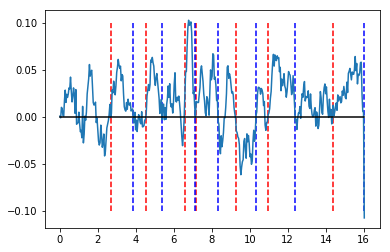

In [145]:
xt=run_score(Fw,0)
temp=intFw[crit,:]*Tacq*4
x=arange(0,xt.shape[0])*Tacq*4
plot(x,xt)
plot(x,xt*0, 'k')
vlines(temp[:,0], -0.1, 0.1, linestyles='--', color='r')
vlines(temp[:,1], -0.1, 0.1,linestyles='--', color='b')

##   Bootstrap?

